In [87]:
import os
import numpy as np
import sys
print(sys.executable)
import sys
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight


/home/nwertheim/miniconda3/bin/python


In [88]:
save_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA.npy")
target_data = np.load(save_dir, allow_pickle=True)
print(len(target_data))
print(target_data[0])
num_none_preterm = sum(1 for item in target_data if item['preterm'] is None)
print(f"Number of instances with None in 'preterm': {num_none_preterm}")
target_data = [item for item in target_data if item['preterm'] is not None]
print(f"Remaining instances after deletion: {len(target_data)}")

target_data = pd.DataFrame(target_data)



1002
{'record_name': 'Hopper-2023_05_25_12_03_38-0000010090-0003-chan0', 'signal': array([[-1.70320951],
       [-3.4187519 ],
       [-2.48399421],
       ...,
       [ 0.73116871],
       [ 0.4095313 ],
       [ 0.95039407]], shape=(65820, 1)), 'fs': 20, 'preterm': 0}
Number of instances with None in 'preterm': 144
Remaining instances after deletion: 858


In [89]:
def extract_windows_from_signal(signal, window_size):
    signal = signal.squeeze()  # (seq_len,)
    total_length = len(signal)
    n_windows = total_length // window_size
    windows = np.array([
        signal[i * window_size: (i + 1) * window_size]
        for i in range(n_windows)
    ])
    return windows  # shape (n_windows, window_size)

def create_windowed_dataset(df, window_size):
    windowed_data = []  

    for idx, row in df.iterrows():
        record_name = row['record_name']
        label = row['preterm']
        signal = row['signal']  # shape (seq_len, 1)

        windows = extract_windows_from_signal(signal, window_size)

        for i, window in enumerate(windows):
            windowed_data.append({
                'record_name': record_name,
                'window_id': i,
                'window': window.astype(np.float32),
                'label': label
            })

    return pd.DataFrame(windowed_data)


def split_data(df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Splits must sum to 1."

    # First split off the test set
    train_val_df, test_df = train_test_split(df, test_size=test_ratio, stratify=df['label'], random_state=42)

    # Now split train and val from the remaining part
    val_adjusted = val_ratio / (train_ratio + val_ratio)
    train_df, val_df = train_test_split(train_val_df, test_size=val_adjusted, stratify=train_val_df['label'], random_state=42)

    return train_df, val_df, test_df

In [90]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        window = torch.tensor(row['window']).unsqueeze(0)  # shape (1, window_size)
        label = torch.tensor(row['label'], dtype=torch.float32)
        return window, label

def create_dataloaders(train_df, val_df, test_df, batch_size=32):
    train_loader = DataLoader(TimeSeriesWindowDataset(train_df), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TimeSeriesWindowDataset(val_df), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TimeSeriesWindowDataset(test_df), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


In [91]:
window_size = 12000

# 1. Create windows
windowed_df = create_windowed_dataset(target_data, window_size=window_size)

# 2. Split data
train_df, val_df, test_df = split_data(windowed_df)

# 3. Create DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(train_df, val_df, test_df)
print(len(train_df), len(test_df), len(val_df))

def print_class_distribution(df, name="Dataset"):
    class_counts = df['label'].value_counts().sort_index()
    total_count = len(df)
    
    term_count = class_counts.get(0, 0)  # count for term (0)
    preterm_count = class_counts.get(1, 0)  # count for preterm (1)
    
    term_ratio = term_count / total_count
    preterm_ratio = preterm_count / total_count
    
    print(f"\n{name} class distribution:")
    print(f"Term (0): {term_count} instances, {term_ratio:.2f} ratio")
    print(f"Preterm (1): {preterm_count} instances, {preterm_ratio:.2f} ratio")
    print(f"Total: {total_count} instances")

# For train and test
print_class_distribution(train_df, "Train Set")
print_class_distribution(test_df, "Test Set")


8462 1058 1058

Train Set class distribution:
Term (0): 2155 instances, 0.25 ratio
Preterm (1): 6307 instances, 0.75 ratio
Total: 8462 instances

Test Set class distribution:
Term (0): 269 instances, 0.25 ratio
Preterm (1): 789 instances, 0.75 ratio
Total: 1058 instances


In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, input_length):
        super(CNNClassifier, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # (B, 16, L)
        x = F.relu(self.bn2(self.conv2(x)))  # (B, 32, L)
        x = F.relu(self.bn3(self.conv3(x)))  # (B, 64, L)
        
        x = self.pool(x).squeeze(-1)         # (B, 64)
        x = self.classifier(x)               # (B, 1)
        return x


In [93]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import torch

def plot_roc_and_pr_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = average_precision_score(y_true, y_probs)
    
    plt.figure(figsize=(12, 5))

    # Plot ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')

    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

from sklearn.utils.class_weight import compute_class_weight
import torch

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cuda'):
    model = model.to(device)
    
    # Extract labels from the dataset to compute class weights
    all_labels = []
    for x_batch, y_batch in train_loader:
        all_labels.extend(y_batch.numpy())  # Extract labels from the batch

    # Compute class weights based on the label distribution in the training set
    class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # <-- convert list to np.array
    y=np.array(all_labels)     # ensure labels are also a NumPy array
    )
    
    # Convert class weights to a tensor
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    
    # Create the loss function with class weights
    # class_weights[1] corresponds to the minority (positive) class
    pos_weight = torch.tensor(class_weights[1] / class_weights[0], dtype=torch.float).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize lists to store true labels and predicted probabilities
    all_labels = []
    all_probs = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)  # (B, 1, window_size)
            y_batch = y_batch.to(device).unsqueeze(1)  # (B, 1)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x_batch.size(0)

        # Evaluate on the validation set and collect labels and predictions
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).unsqueeze(1)

                outputs = model(x_batch)
                probs = torch.sigmoid(outputs).cpu().numpy()  # Get probabilities

                all_labels.extend(y_batch.cpu().numpy().flatten())  # True labels
                all_probs.extend(probs.flatten())  # Predicted probabilities

        # Calculate validation loss and accuracy
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader.dataset):.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # After each epoch, plot ROC and PR curves
        plot_roc_and_pr_curve(all_labels, all_probs)
    
    return model


    
      

In [94]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_with_metrics(model, dataloader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            outputs = model(x_batch)
            probs = torch.sigmoid(outputs)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item() * x_batch.size(0)

            all_probs.append(probs.cpu())
            all_preds.append((probs >= 0.5).float().cpu())
            all_labels.append(y_batch.cpu())

    all_probs = torch.cat(all_probs).numpy().flatten()
    all_preds = torch.cat(all_preds).numpy().flatten()
    all_labels = torch.cat(all_labels).numpy().flatten()

    avg_loss = total_loss / len(dataloader.dataset)
    acc = (all_preds == all_labels).mean()
    auc = roc_auc_score(all_labels, all_probs)
    ap = average_precision_score(all_labels, all_probs)
    
    print(f"Loss: {avg_loss:.4f} | Acc: {acc:.4f} | AUC: {auc:.4f} | AP: {ap:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names=["Term", "Preterm"])
    
    return avg_loss, acc, auc, ap

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


Epoch 1/50 | Train Loss: 0.3379 | Val Loss: 0.3363 | Val Acc: 0.5888


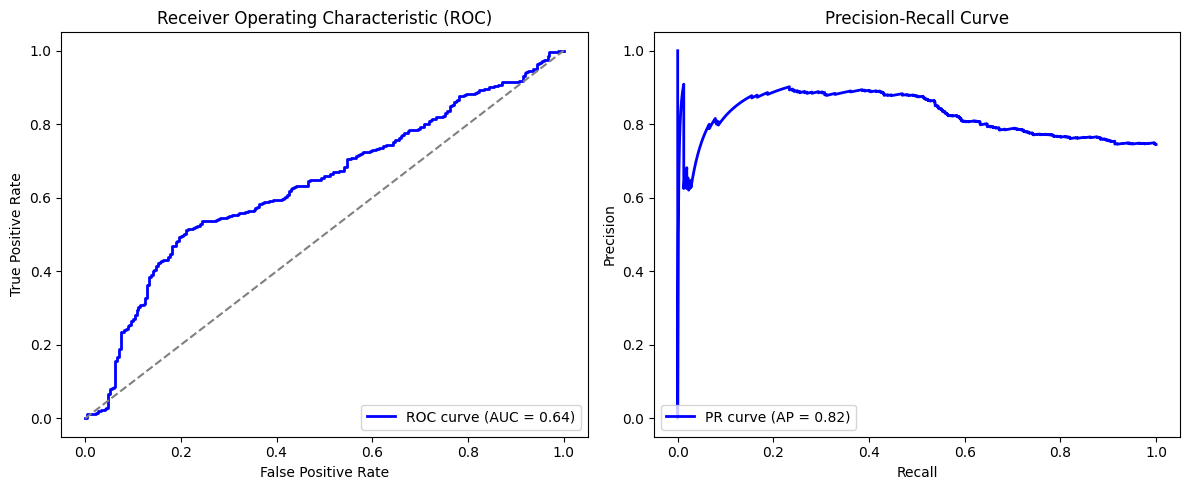

Epoch 2/50 | Train Loss: 0.3350 | Val Loss: 0.3361 | Val Acc: 0.5898


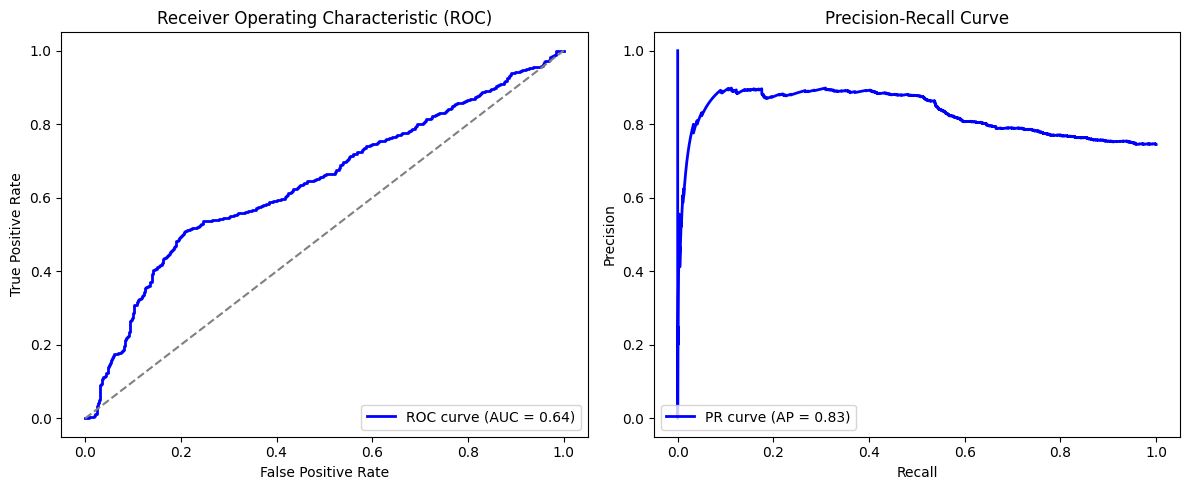

Epoch 3/50 | Train Loss: 0.3330 | Val Loss: 0.3363 | Val Acc: 0.5822


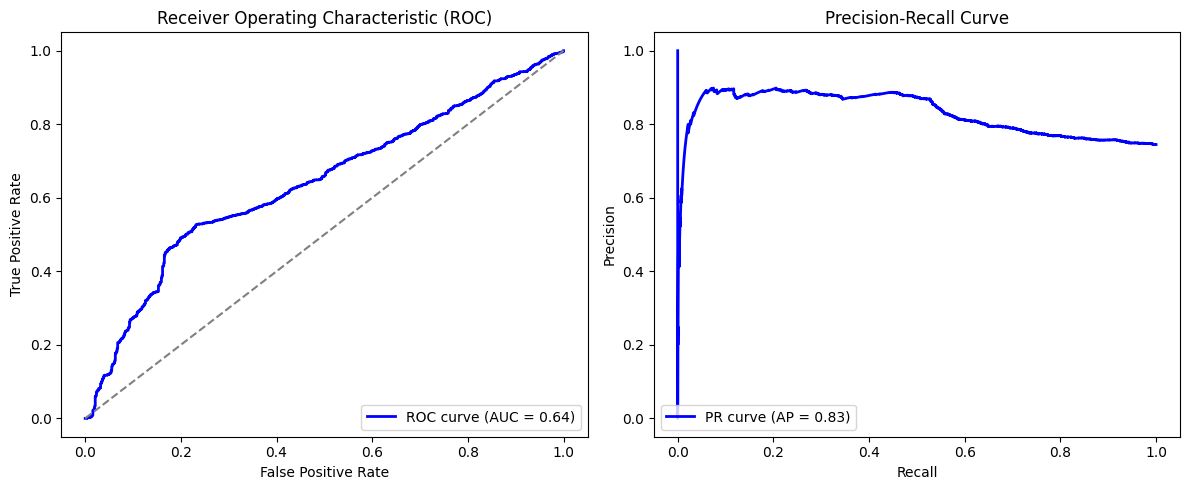

Epoch 4/50 | Train Loss: 0.3337 | Val Loss: 0.3326 | Val Acc: 0.5898


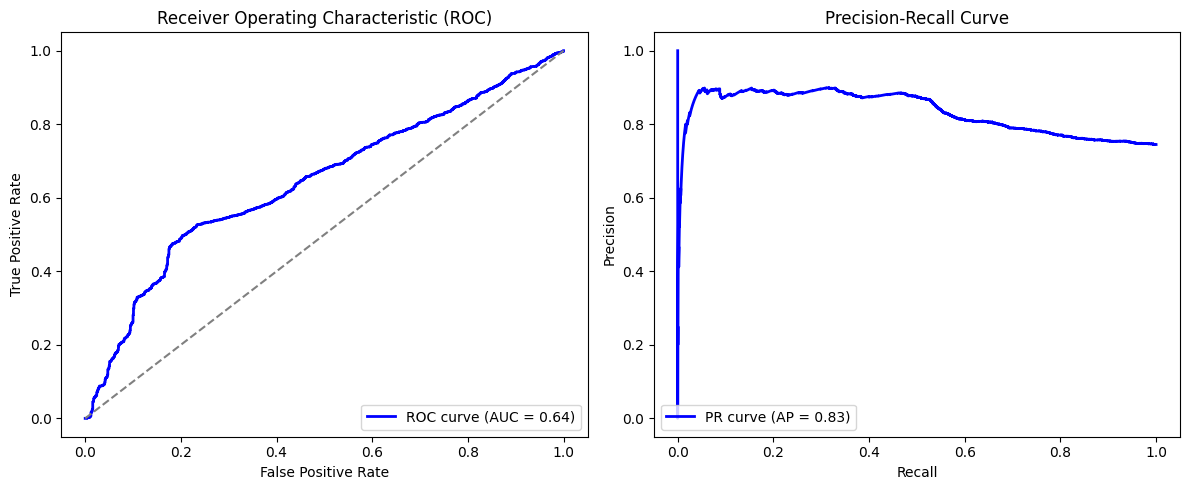

Epoch 5/50 | Train Loss: 0.3324 | Val Loss: 0.3311 | Val Acc: 0.6163


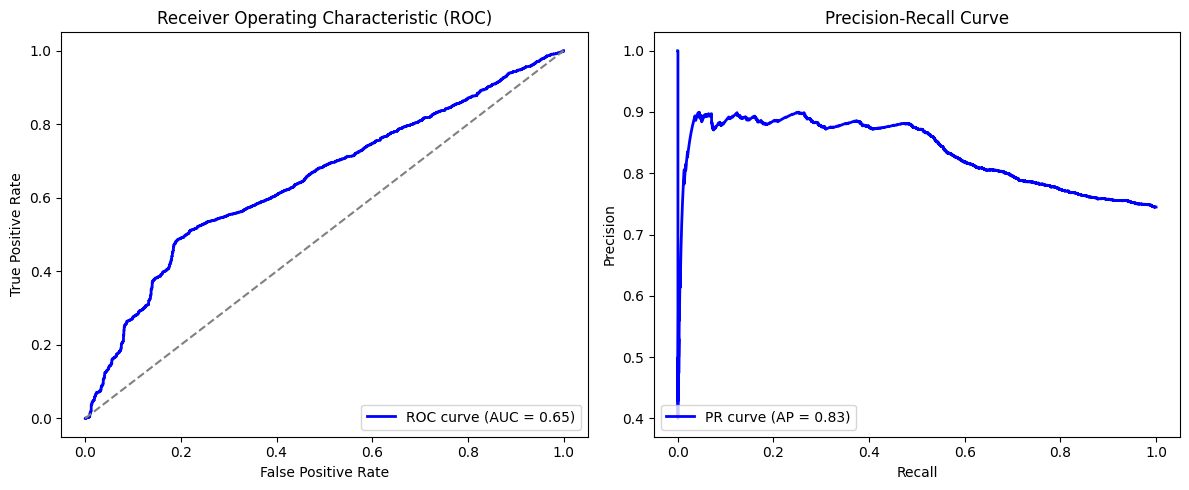

Epoch 6/50 | Train Loss: 0.3326 | Val Loss: 0.3310 | Val Acc: 0.5860


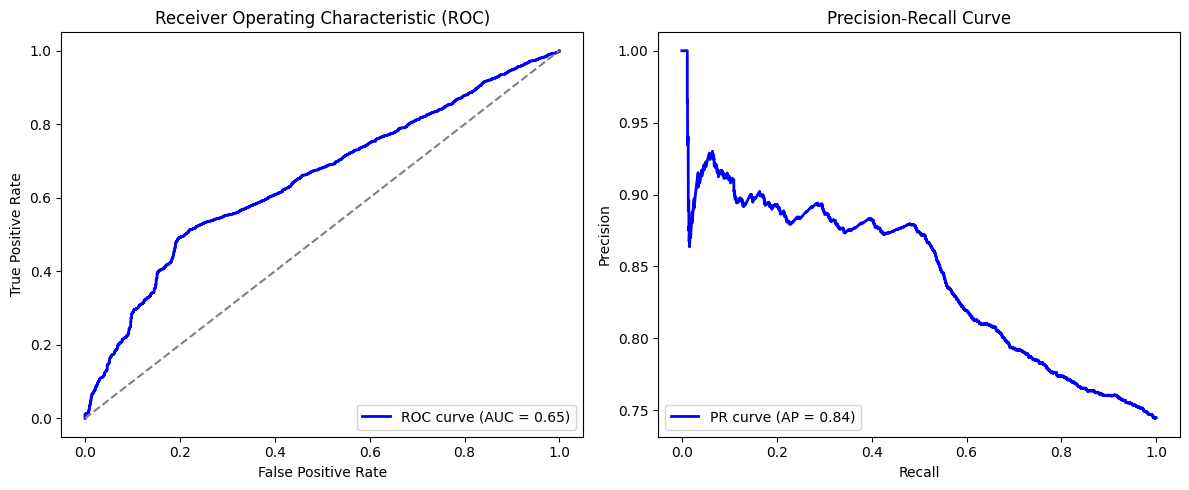

Epoch 7/50 | Train Loss: 0.3321 | Val Loss: 0.3302 | Val Acc: 0.5955


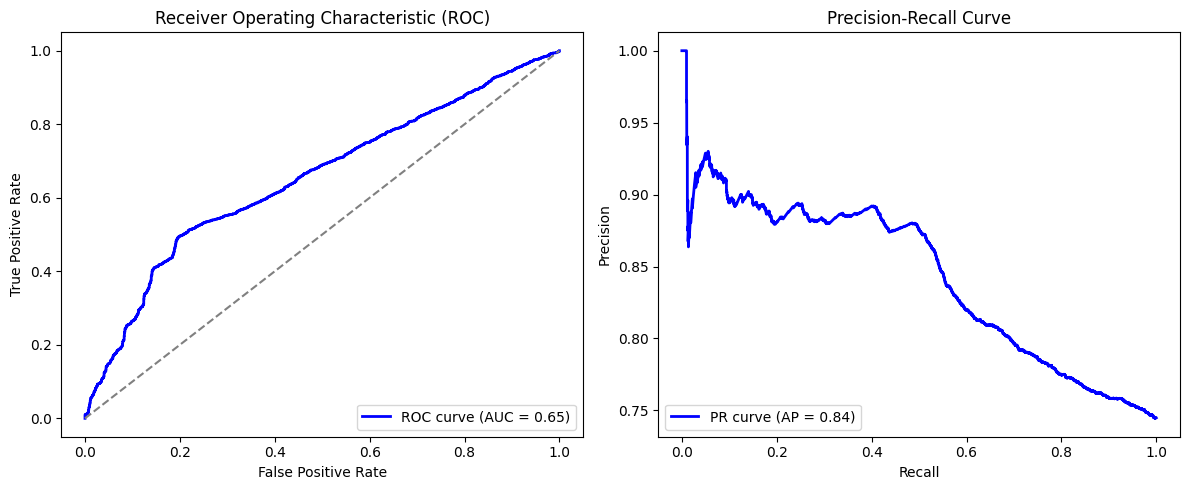

Epoch 8/50 | Train Loss: 0.3302 | Val Loss: 0.3295 | Val Acc: 0.5898


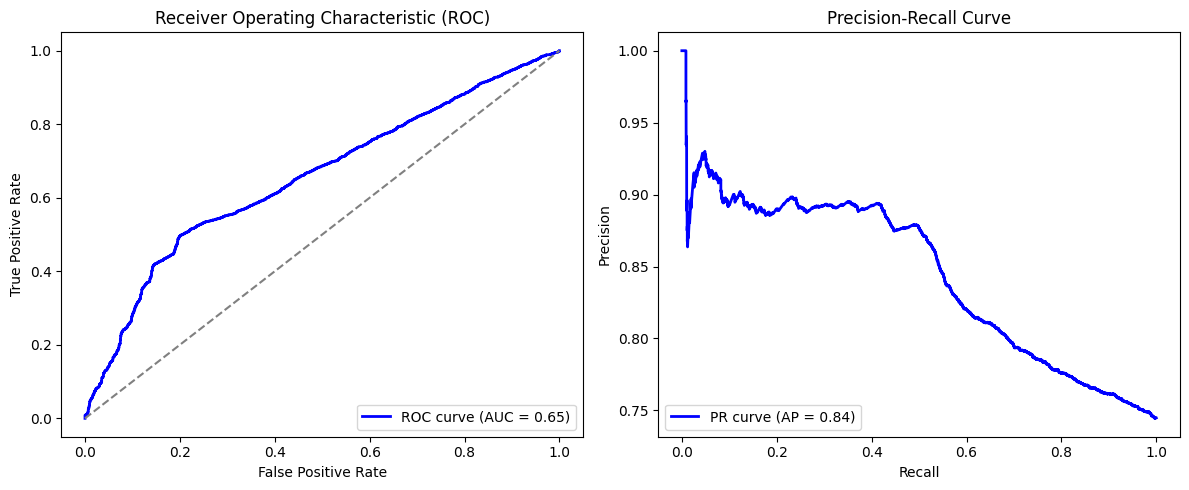

Epoch 9/50 | Train Loss: 0.3315 | Val Loss: 0.3310 | Val Acc: 0.6399


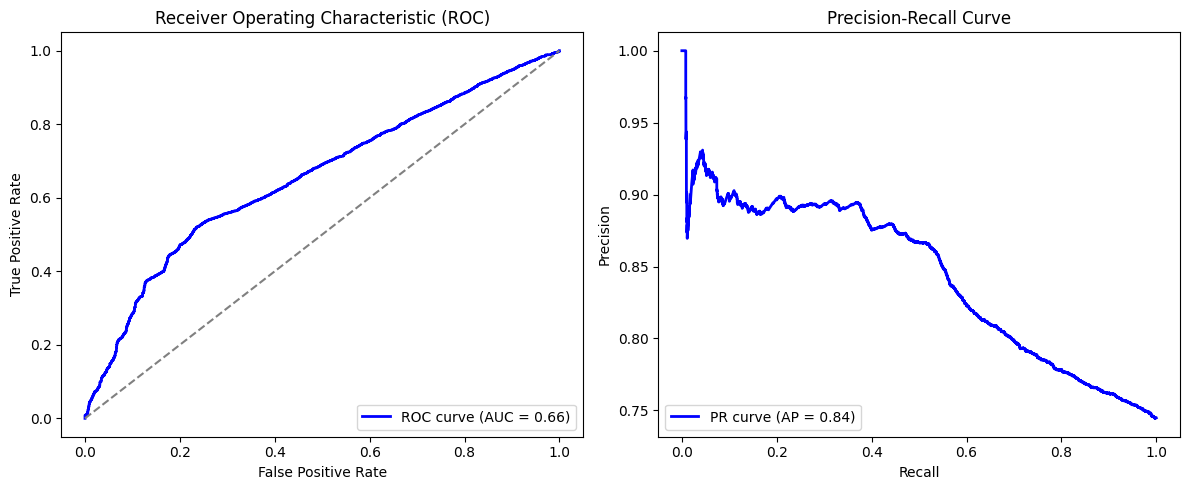

Epoch 10/50 | Train Loss: 0.3298 | Val Loss: 0.3293 | Val Acc: 0.6342


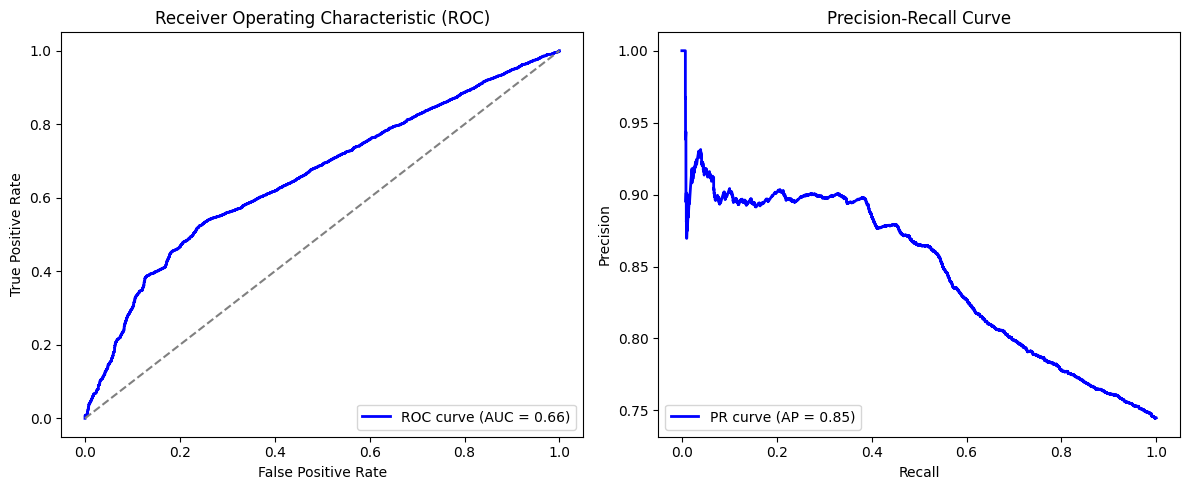

Epoch 11/50 | Train Loss: 0.3295 | Val Loss: 0.3325 | Val Acc: 0.5879


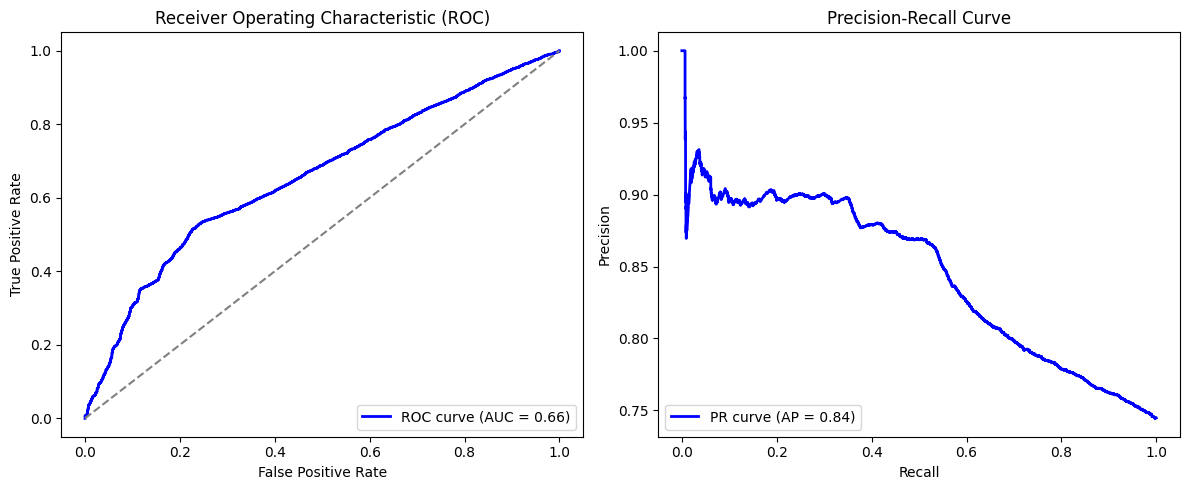

Epoch 12/50 | Train Loss: 0.3298 | Val Loss: 0.3285 | Val Acc: 0.5936


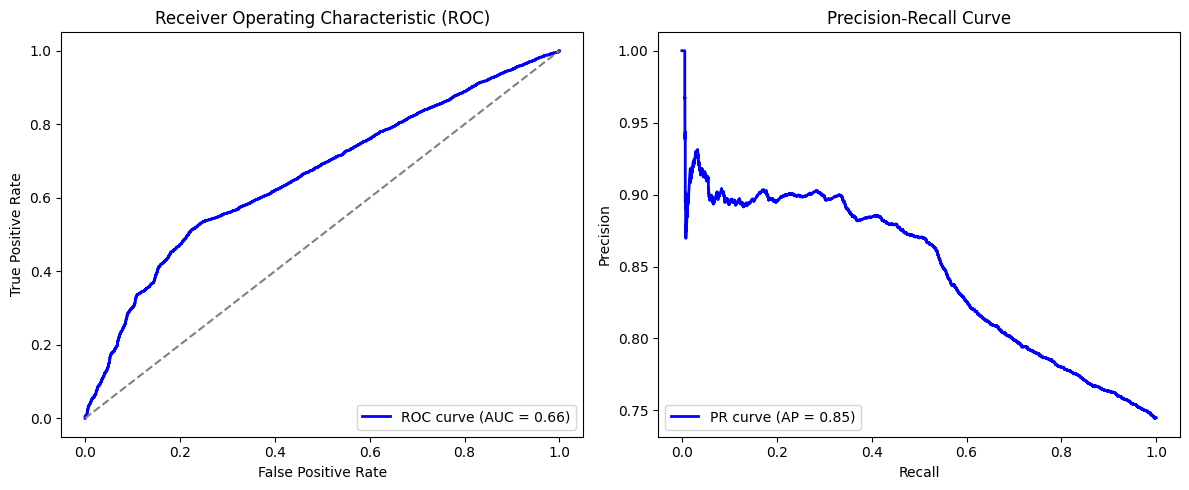

Epoch 13/50 | Train Loss: 0.3285 | Val Loss: 0.3295 | Val Acc: 0.5832


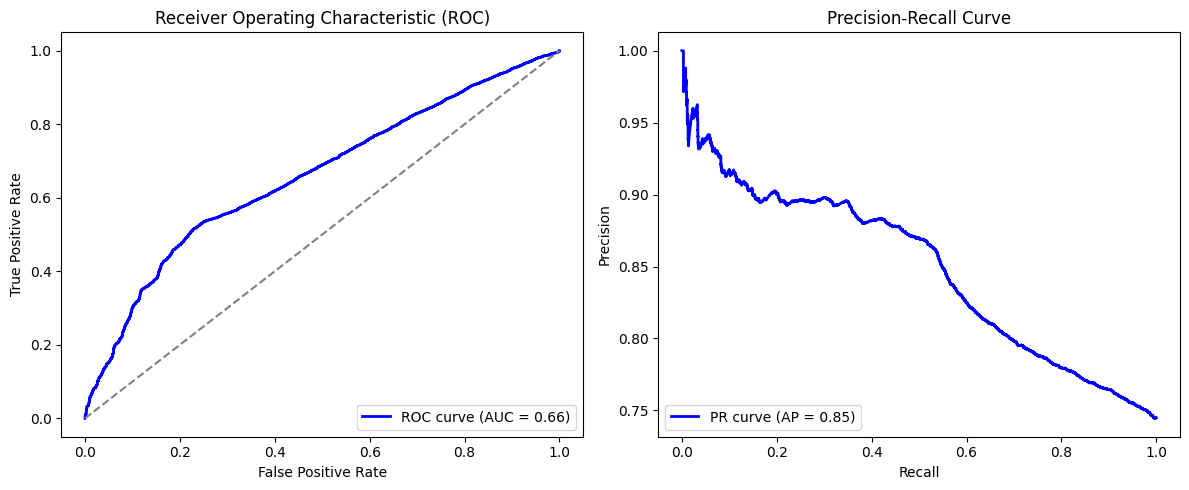

Epoch 14/50 | Train Loss: 0.3293 | Val Loss: 0.3233 | Val Acc: 0.6002


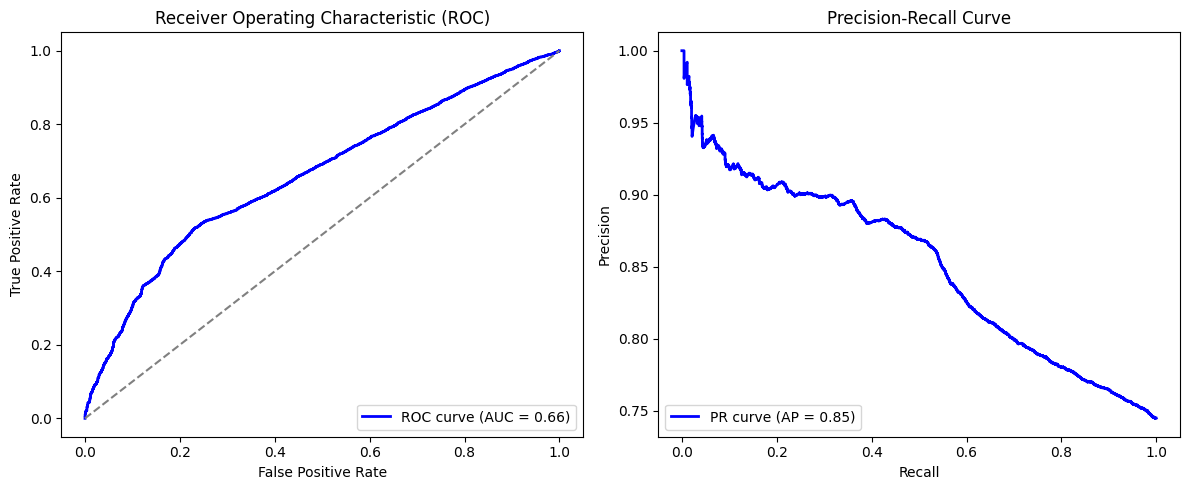

Epoch 15/50 | Train Loss: 0.3246 | Val Loss: 0.3458 | Val Acc: 0.4357


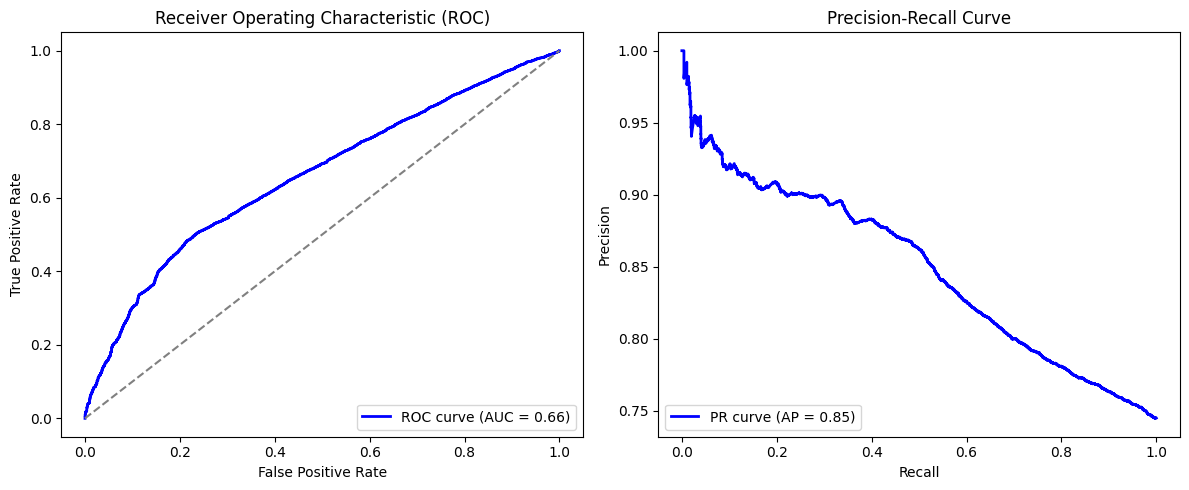

Epoch 16/50 | Train Loss: 0.3249 | Val Loss: 0.3564 | Val Acc: 0.5974


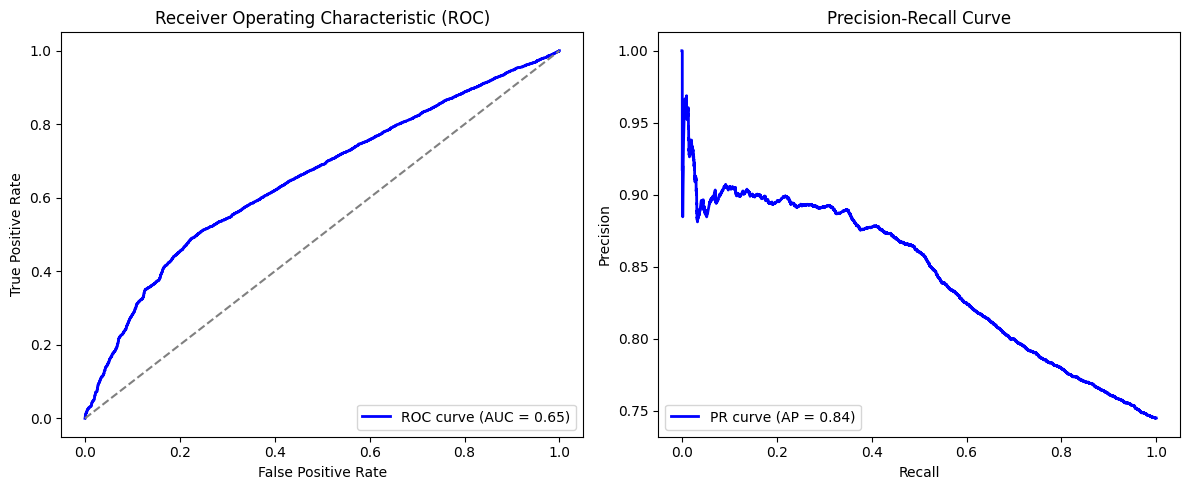

Epoch 17/50 | Train Loss: 0.3269 | Val Loss: 0.3269 | Val Acc: 0.6172


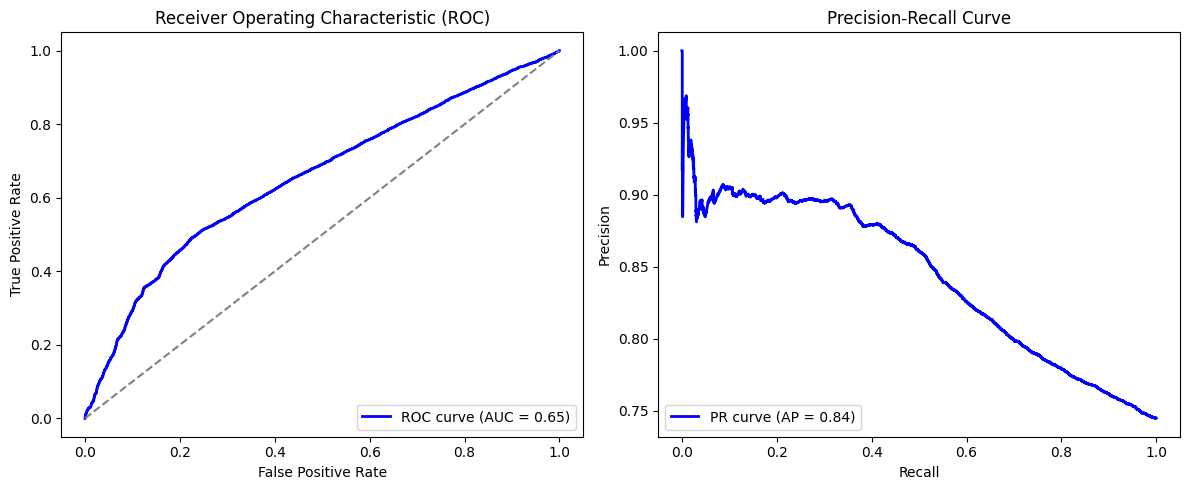

Epoch 18/50 | Train Loss: 0.3228 | Val Loss: 0.3325 | Val Acc: 0.5898


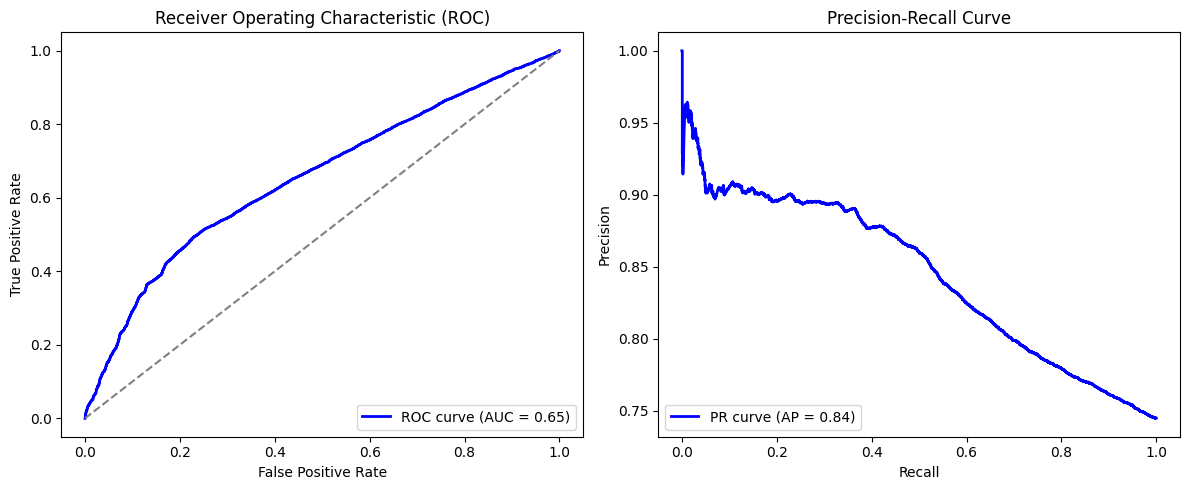

Epoch 19/50 | Train Loss: 0.3205 | Val Loss: 0.3233 | Val Acc: 0.5860


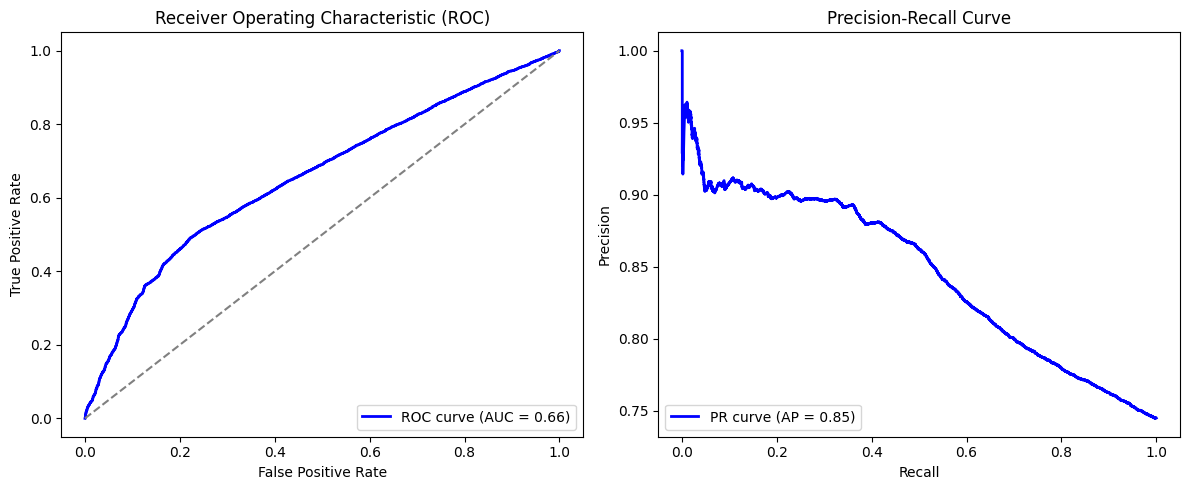

Epoch 20/50 | Train Loss: 0.3197 | Val Loss: 0.3159 | Val Acc: 0.5841


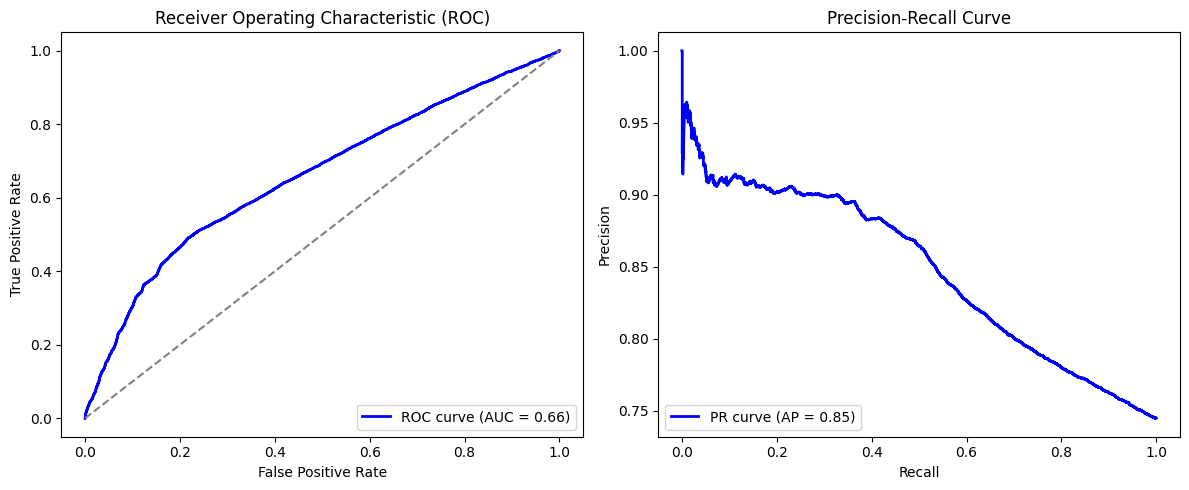

Epoch 21/50 | Train Loss: 0.3189 | Val Loss: 0.3233 | Val Acc: 0.5803


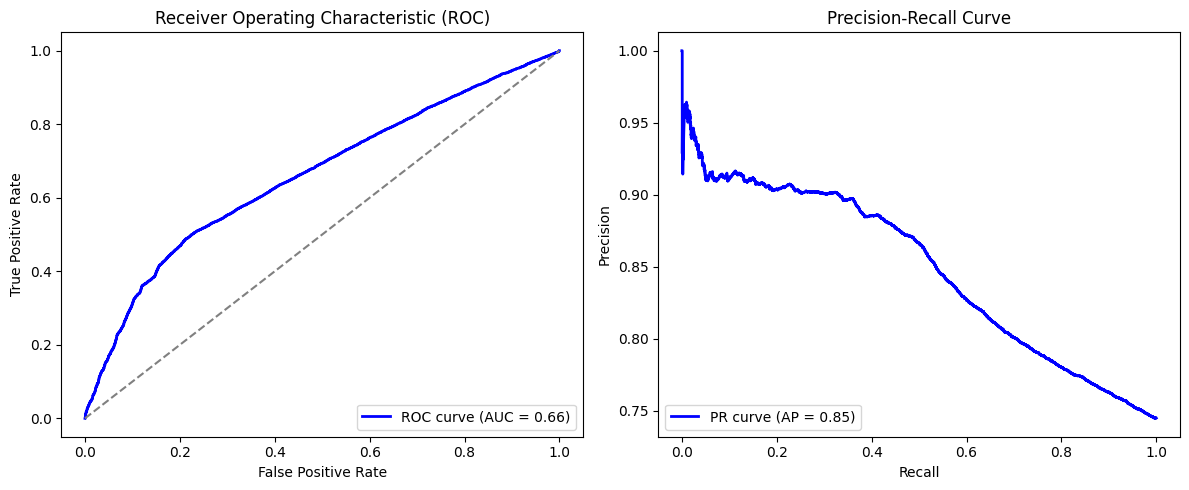

Epoch 22/50 | Train Loss: 0.3168 | Val Loss: 0.3206 | Val Acc: 0.5860


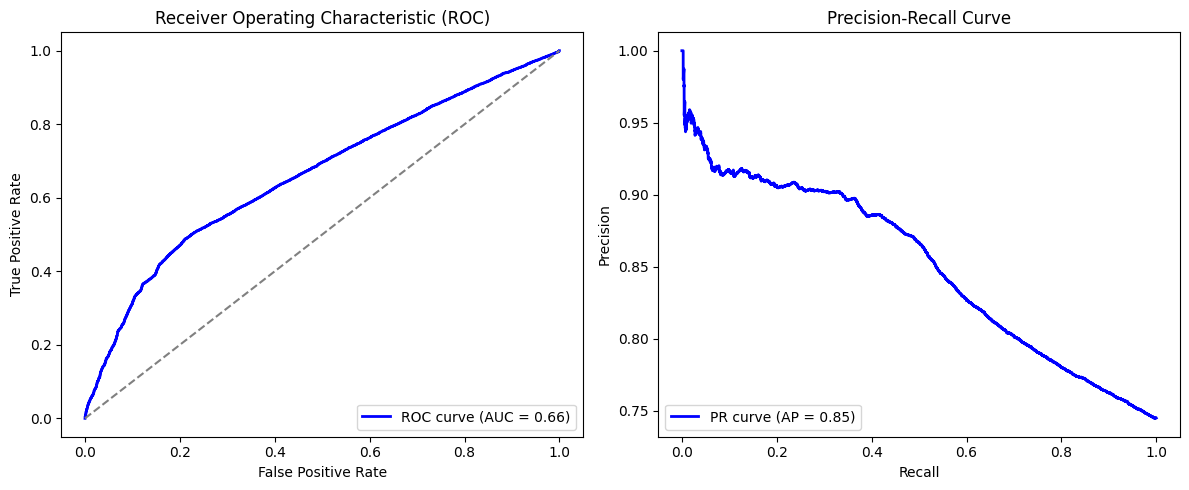

Epoch 23/50 | Train Loss: 0.3142 | Val Loss: 0.3275 | Val Acc: 0.5841


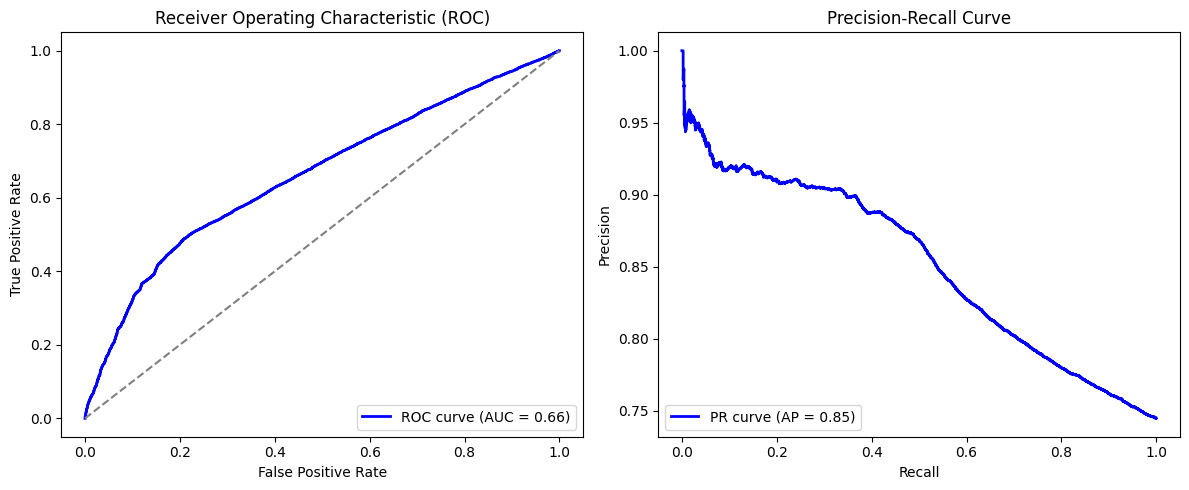

Epoch 24/50 | Train Loss: 0.3173 | Val Loss: 0.3214 | Val Acc: 0.5784


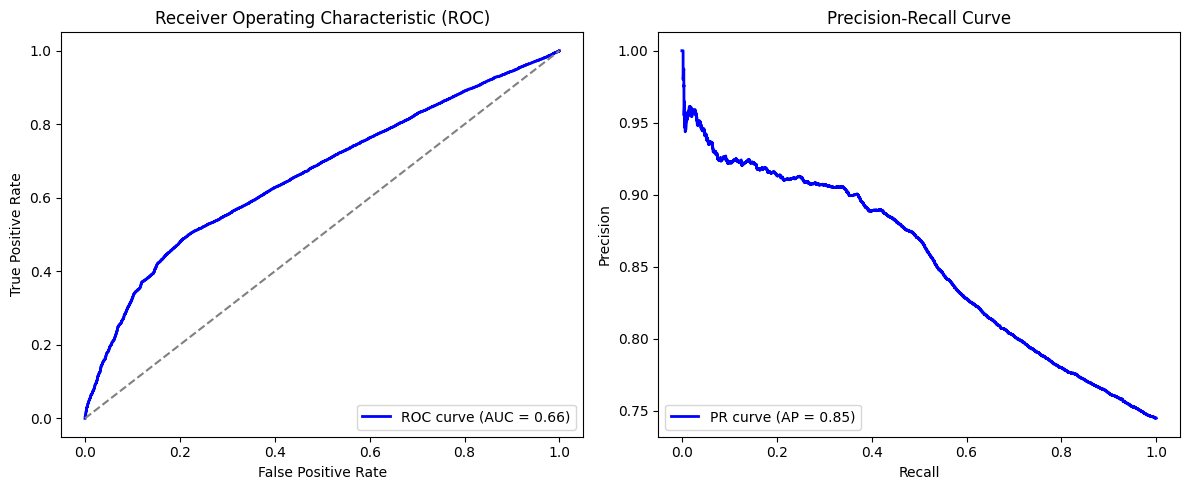

Epoch 25/50 | Train Loss: 0.3170 | Val Loss: 0.3385 | Val Acc: 0.5085


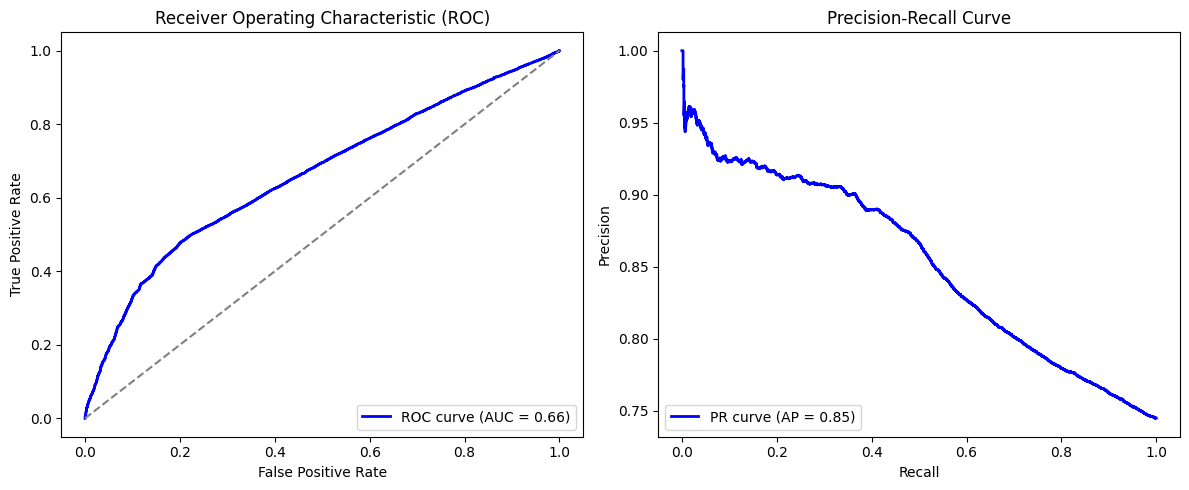

Epoch 26/50 | Train Loss: 0.3151 | Val Loss: 0.3162 | Val Acc: 0.5926


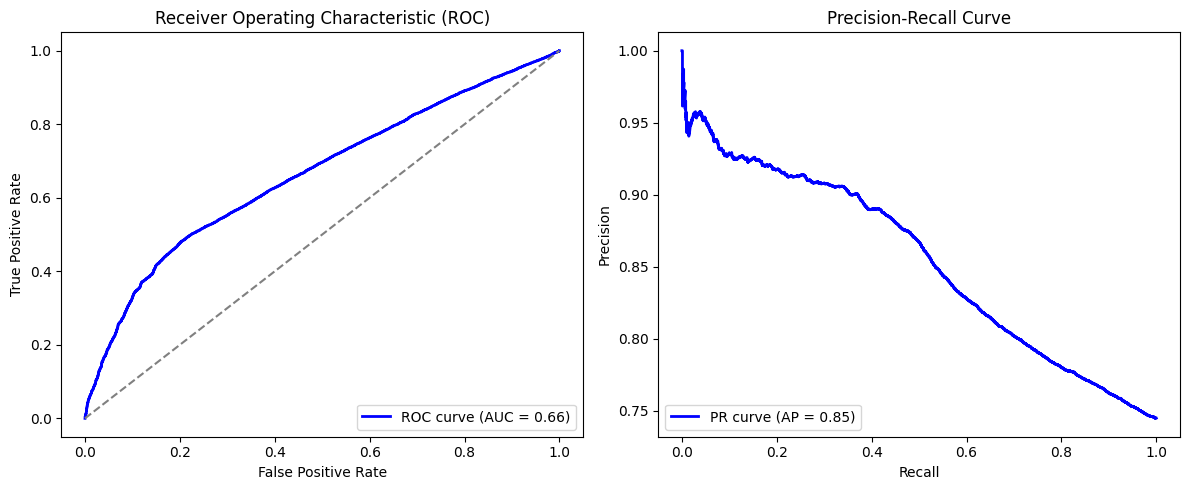

Epoch 27/50 | Train Loss: 0.3155 | Val Loss: 0.3155 | Val Acc: 0.5803


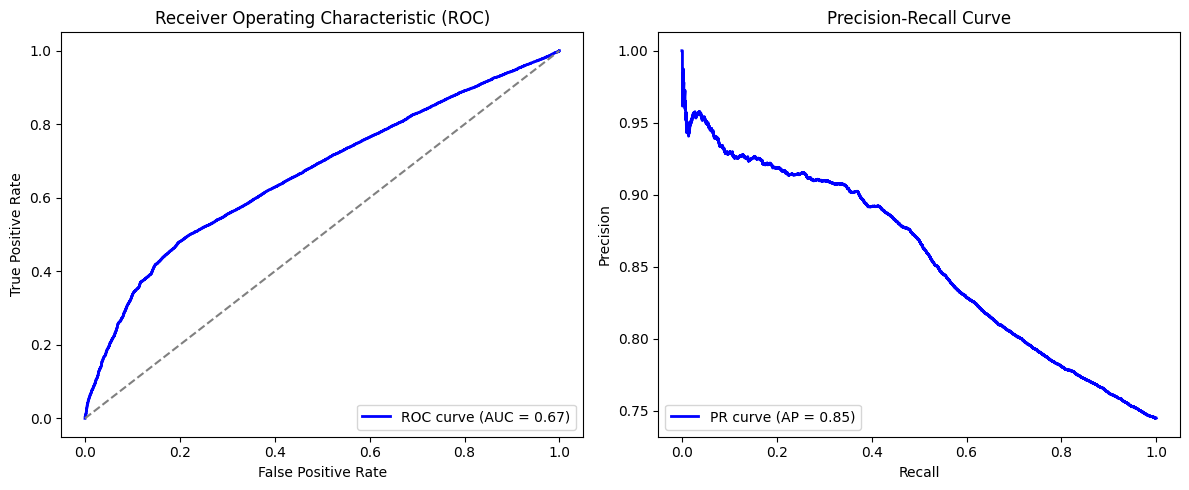

Epoch 28/50 | Train Loss: 0.3135 | Val Loss: 0.3365 | Val Acc: 0.5851


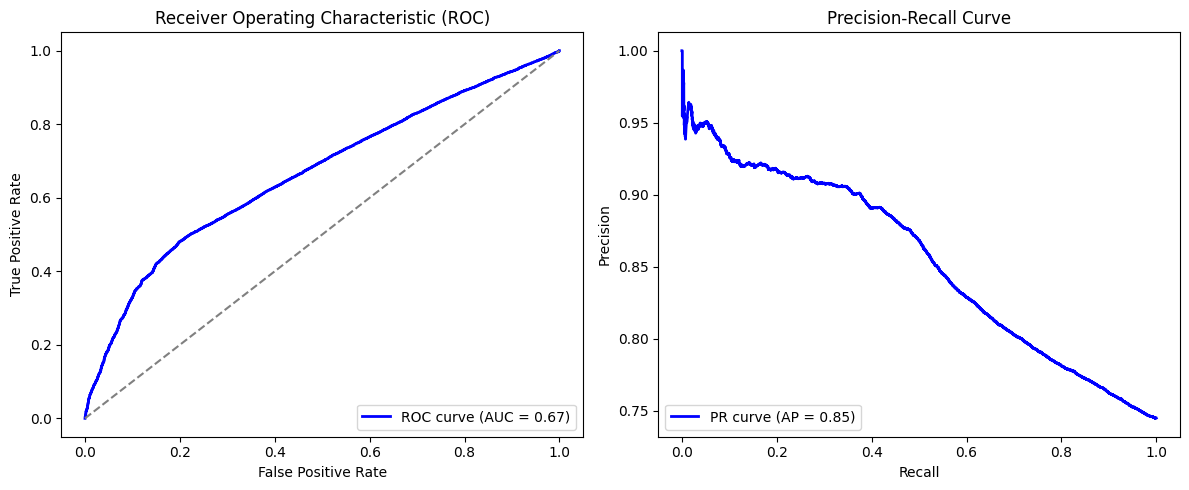

Epoch 29/50 | Train Loss: 0.3143 | Val Loss: 0.3115 | Val Acc: 0.6295


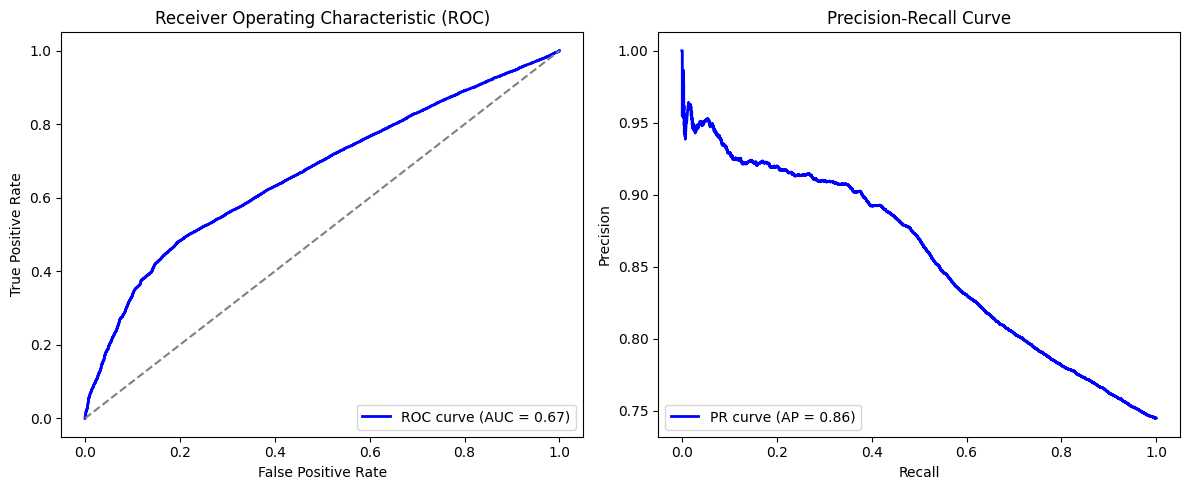

Epoch 30/50 | Train Loss: 0.3123 | Val Loss: 0.3352 | Val Acc: 0.4896


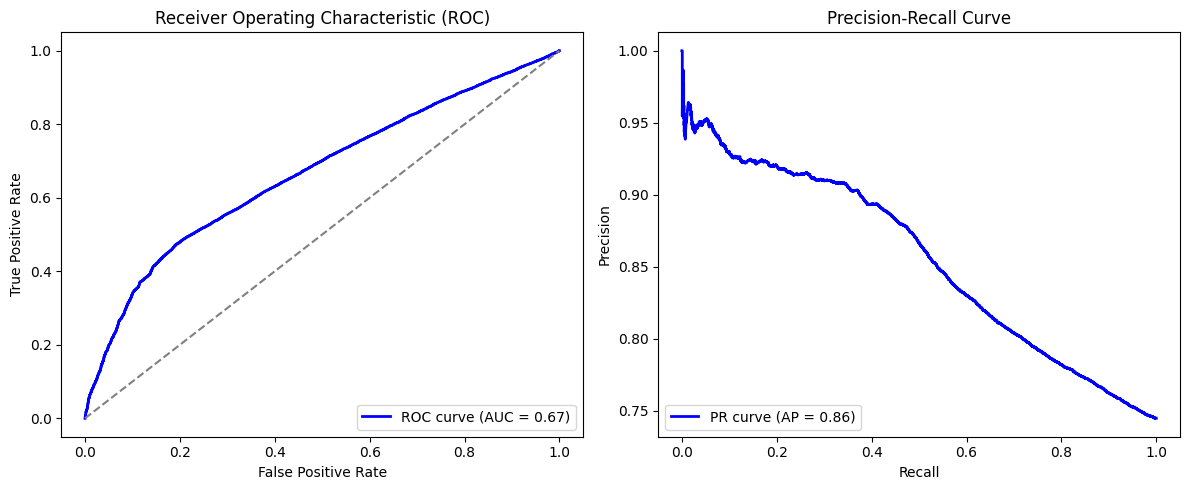

Epoch 31/50 | Train Loss: 0.3132 | Val Loss: 0.3400 | Val Acc: 0.5851


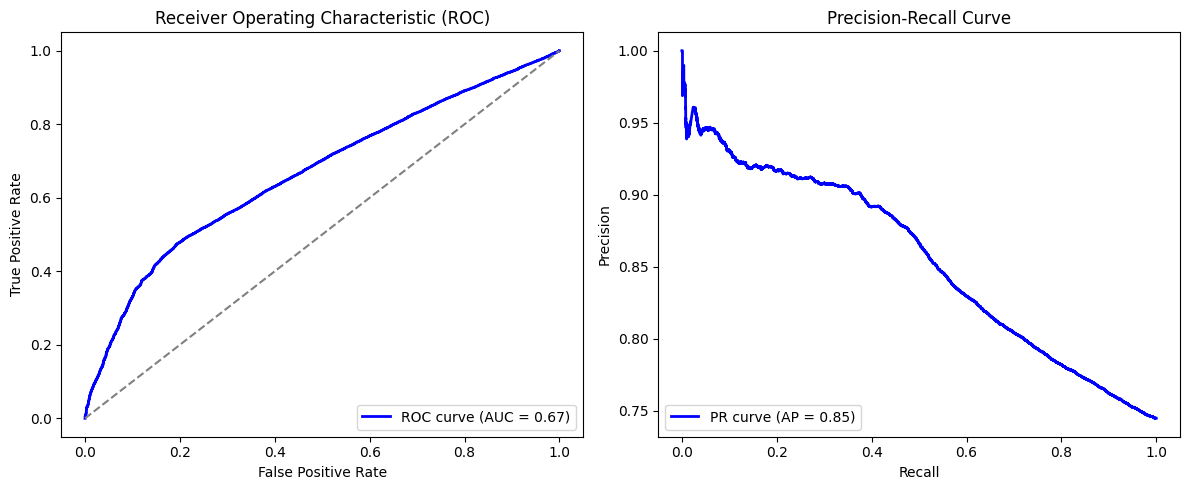

Epoch 32/50 | Train Loss: 0.3143 | Val Loss: 0.3181 | Val Acc: 0.5681


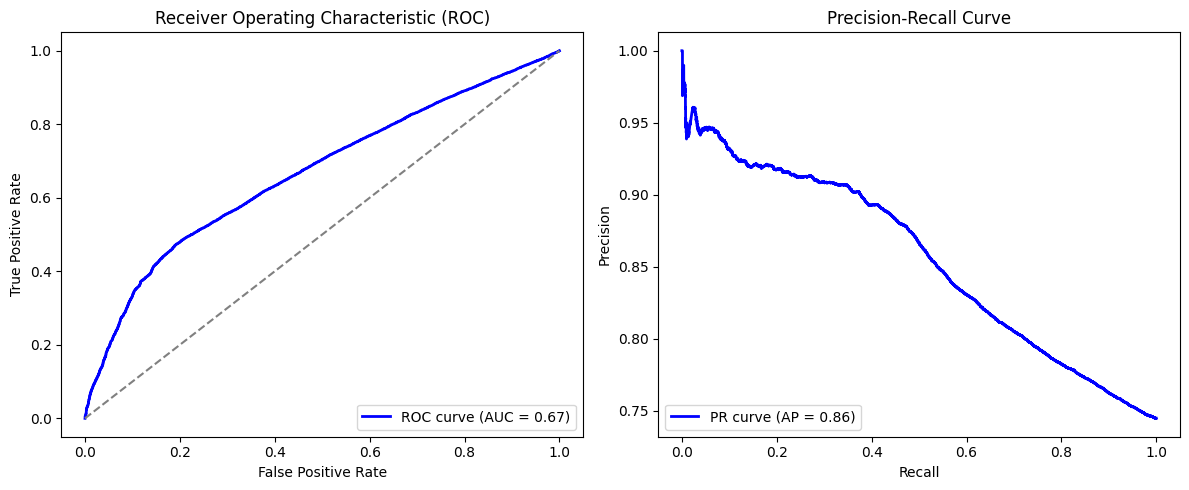

Epoch 33/50 | Train Loss: 0.3131 | Val Loss: 0.3697 | Val Acc: 0.3563


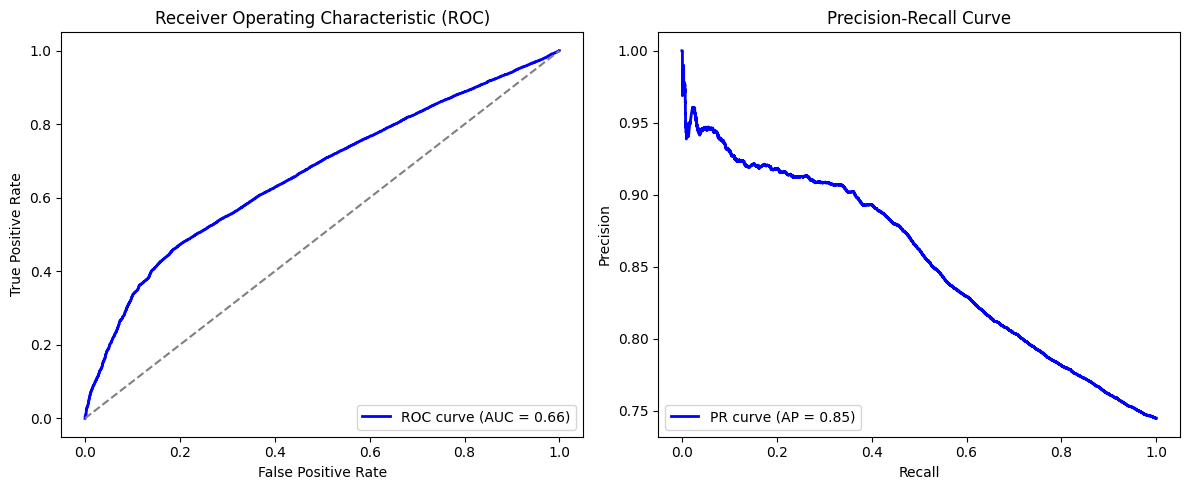

Epoch 34/50 | Train Loss: 0.3123 | Val Loss: 0.3336 | Val Acc: 0.4943


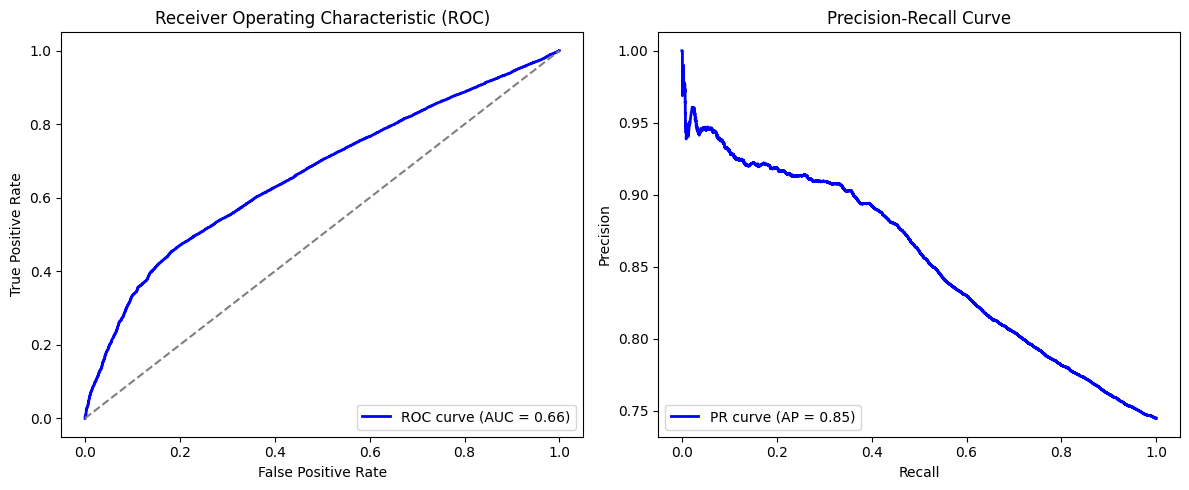

Epoch 35/50 | Train Loss: 0.3144 | Val Loss: 0.4488 | Val Acc: 0.2571


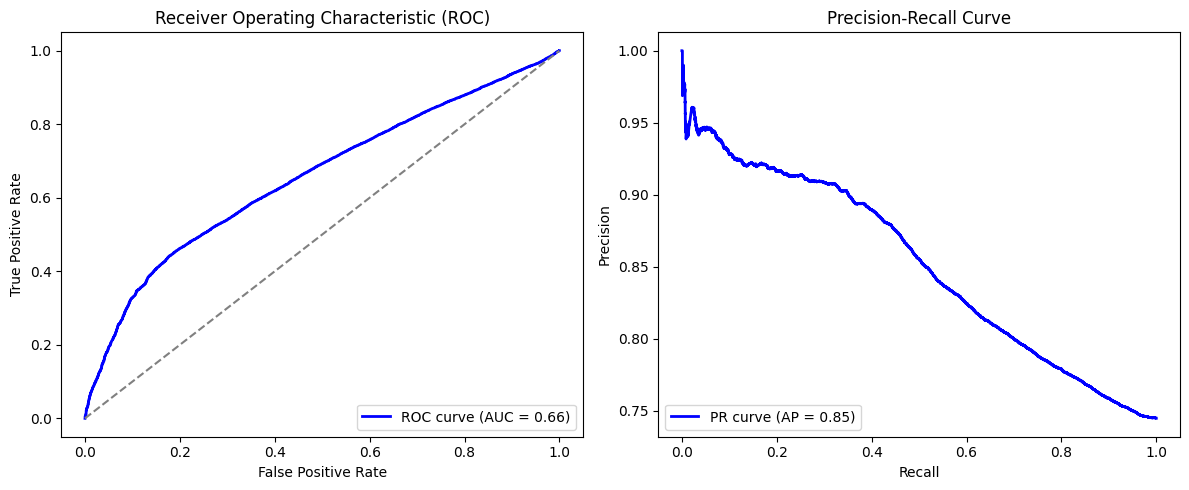

Epoch 36/50 | Train Loss: 0.3128 | Val Loss: 0.3887 | Val Acc: 0.5907


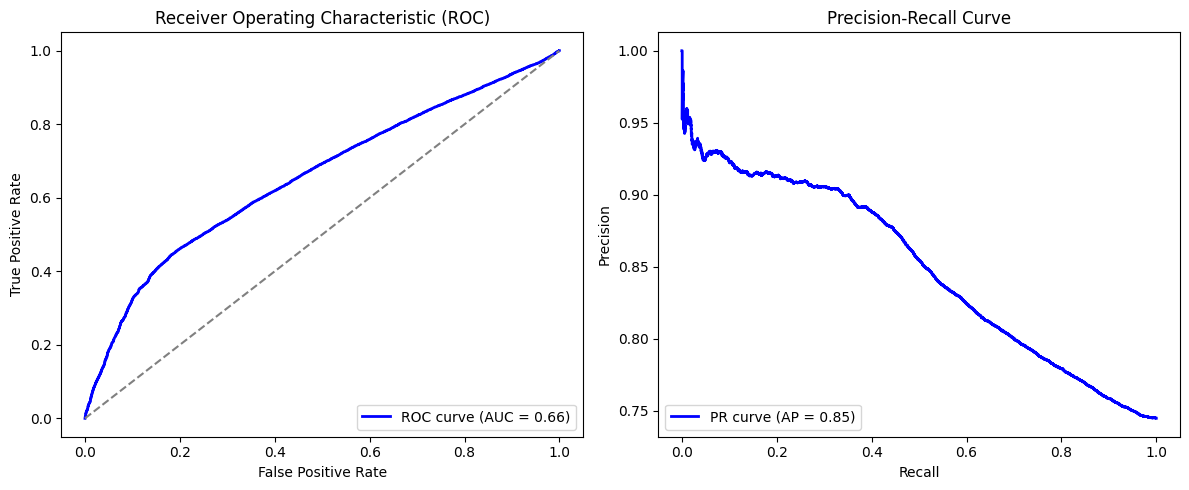

Epoch 37/50 | Train Loss: 0.3133 | Val Loss: 0.4359 | Val Acc: 0.2599


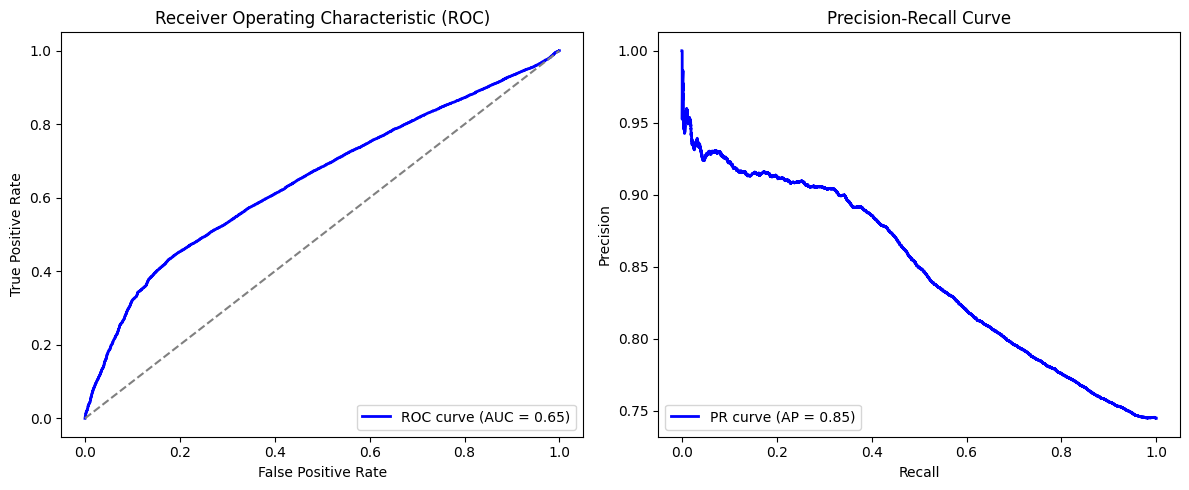

Epoch 38/50 | Train Loss: 0.3115 | Val Loss: 0.3801 | Val Acc: 0.3544


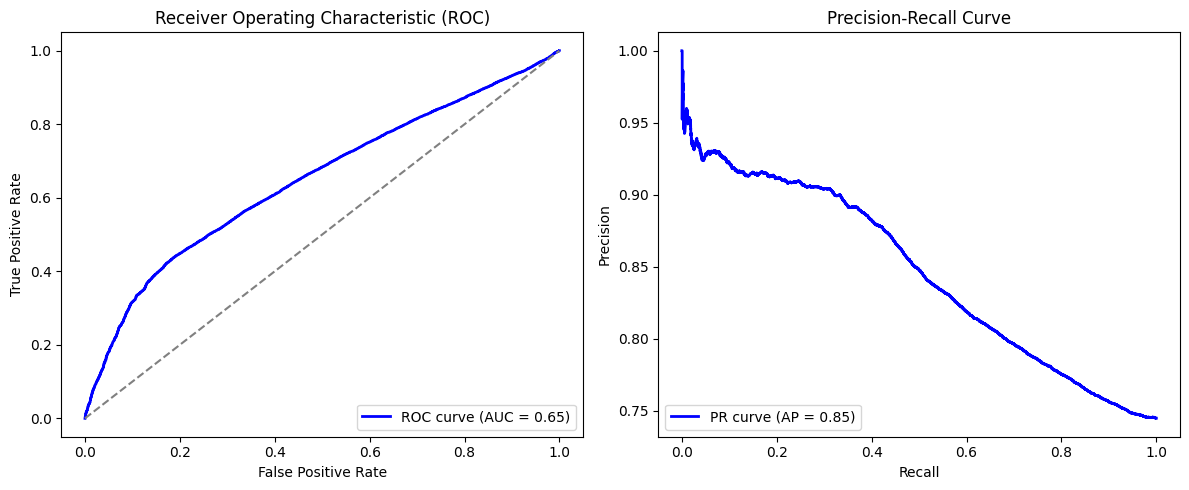

Epoch 39/50 | Train Loss: 0.3133 | Val Loss: 0.3264 | Val Acc: 0.5180


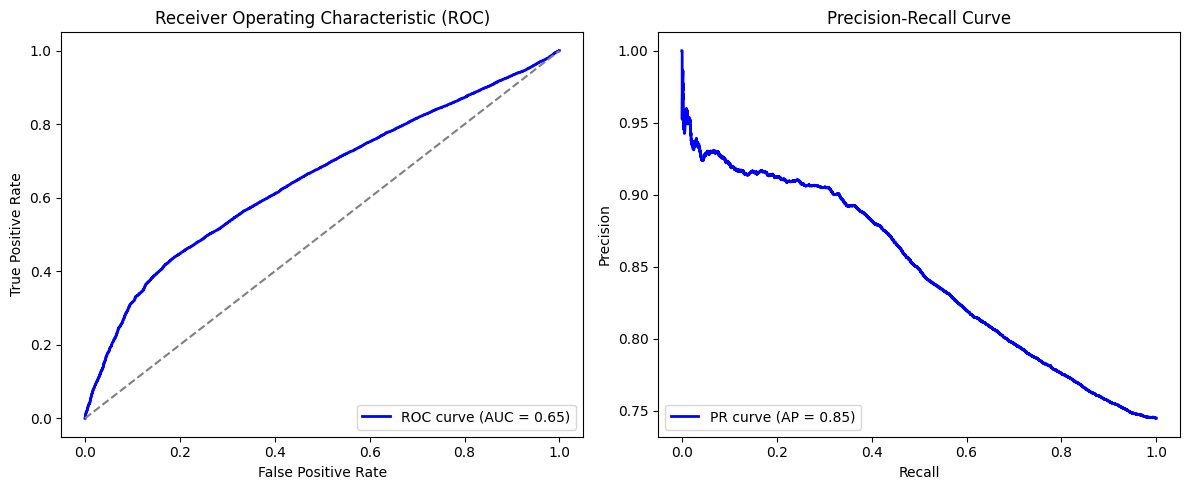

Epoch 40/50 | Train Loss: 0.3112 | Val Loss: 0.3923 | Val Acc: 0.3195


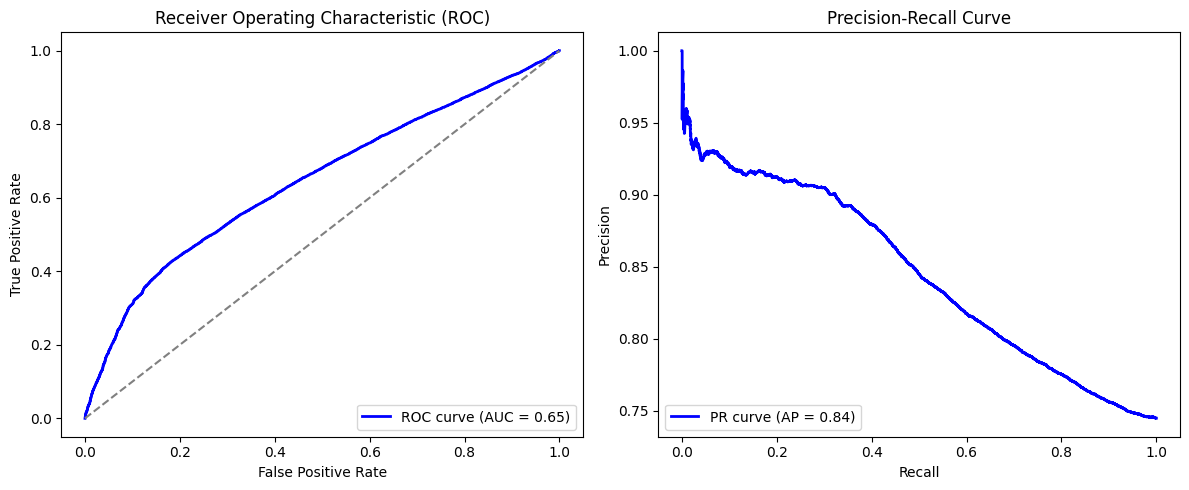

Epoch 41/50 | Train Loss: 0.3109 | Val Loss: 0.4024 | Val Acc: 0.5974


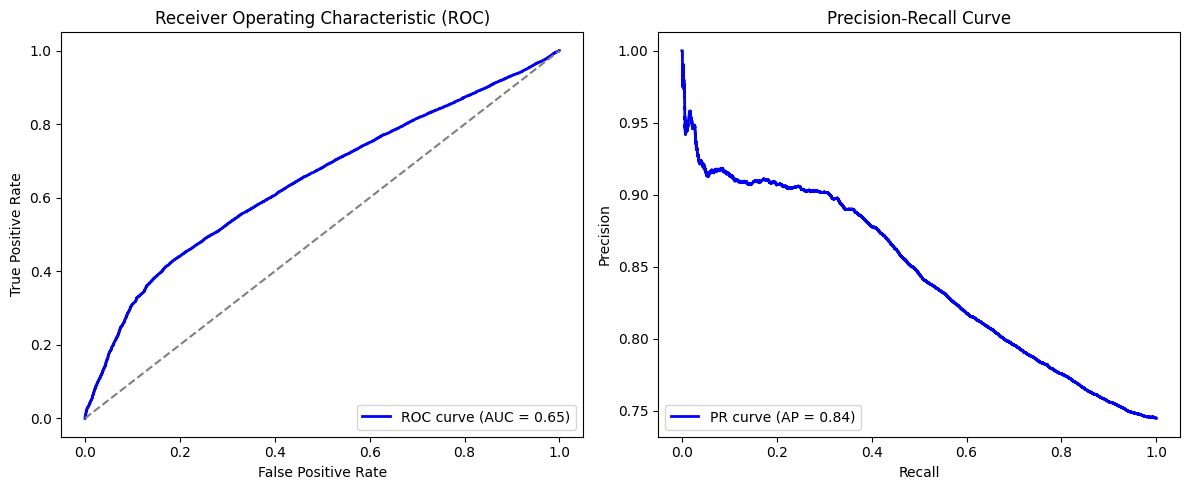

Epoch 42/50 | Train Loss: 0.3120 | Val Loss: 0.4012 | Val Acc: 0.6928


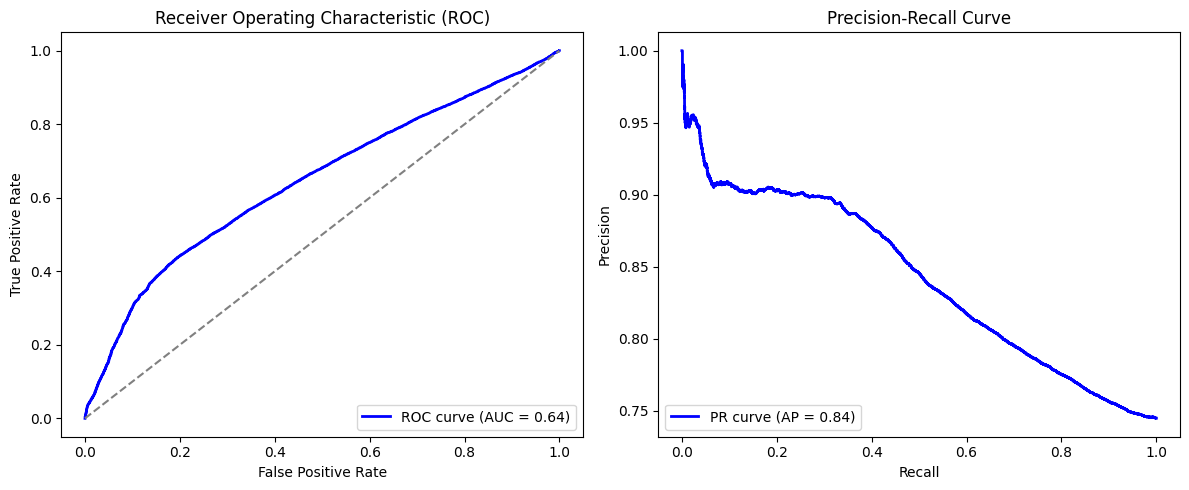

Epoch 43/50 | Train Loss: 0.3121 | Val Loss: 0.3148 | Val Acc: 0.5888


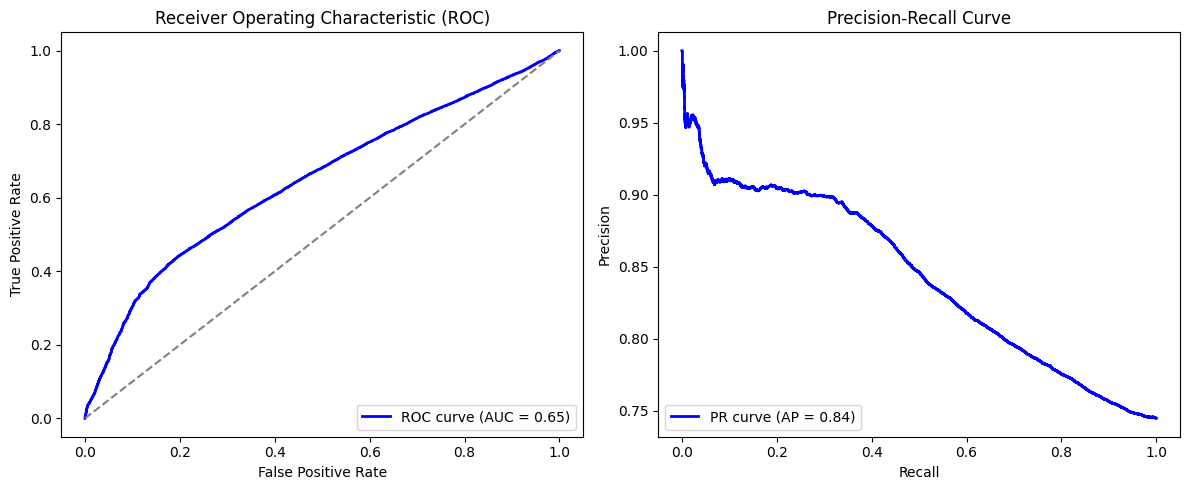

Epoch 44/50 | Train Loss: 0.3120 | Val Loss: 0.3360 | Val Acc: 0.5936


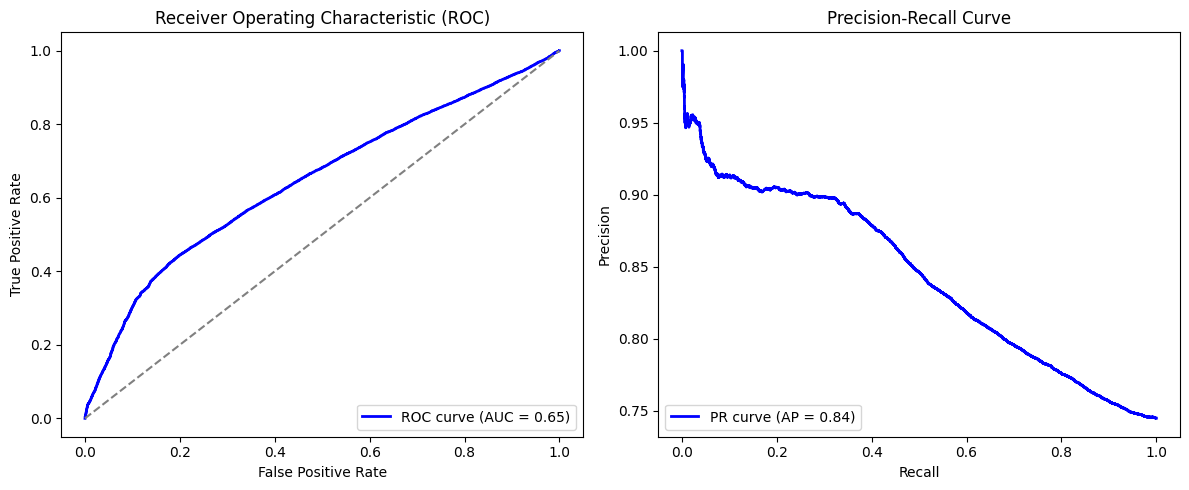

Epoch 45/50 | Train Loss: 0.3128 | Val Loss: 0.3441 | Val Acc: 0.4414


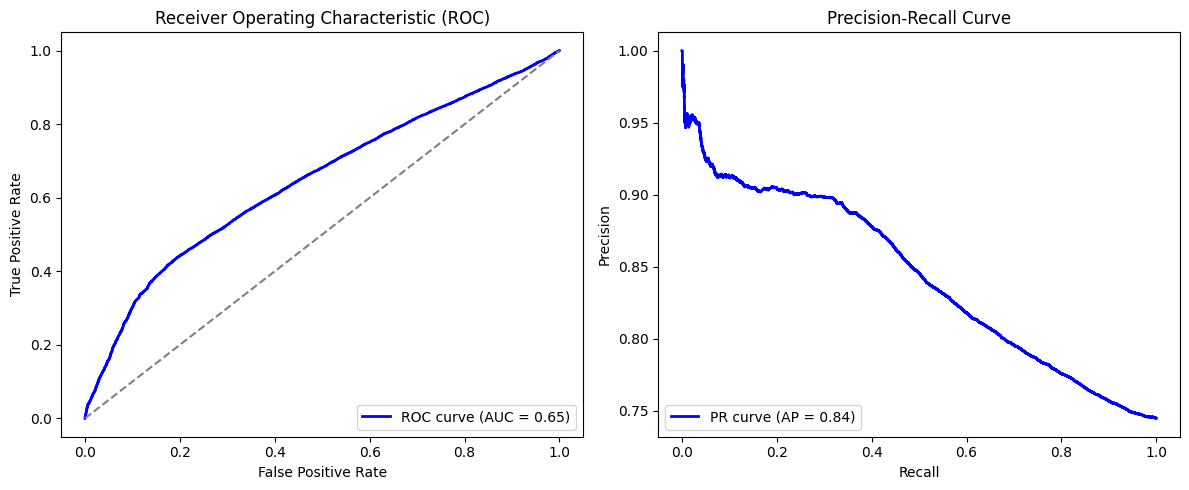

Epoch 46/50 | Train Loss: 0.3139 | Val Loss: 0.3521 | Val Acc: 0.5870


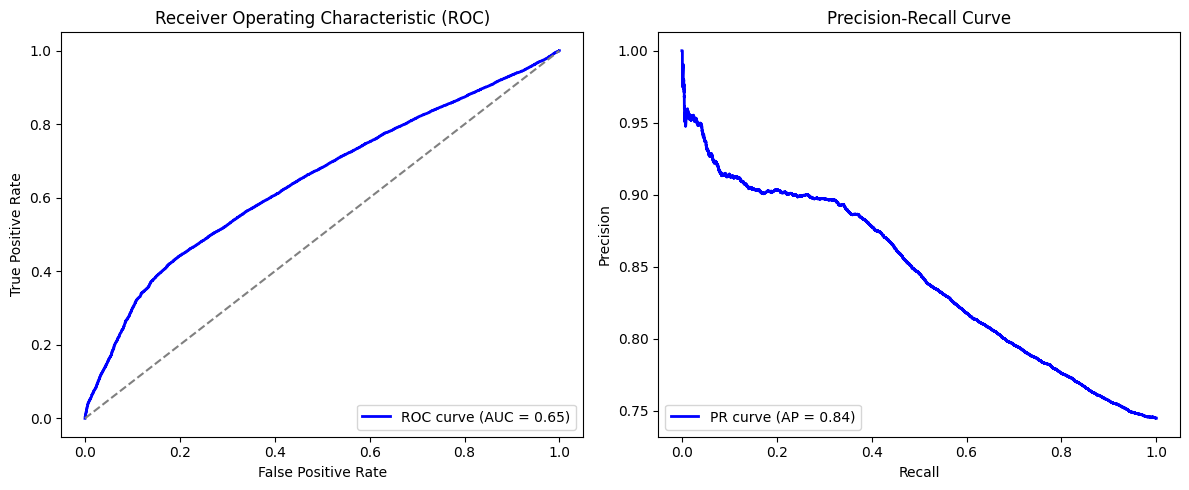

Epoch 47/50 | Train Loss: 0.3121 | Val Loss: 0.3265 | Val Acc: 0.5870


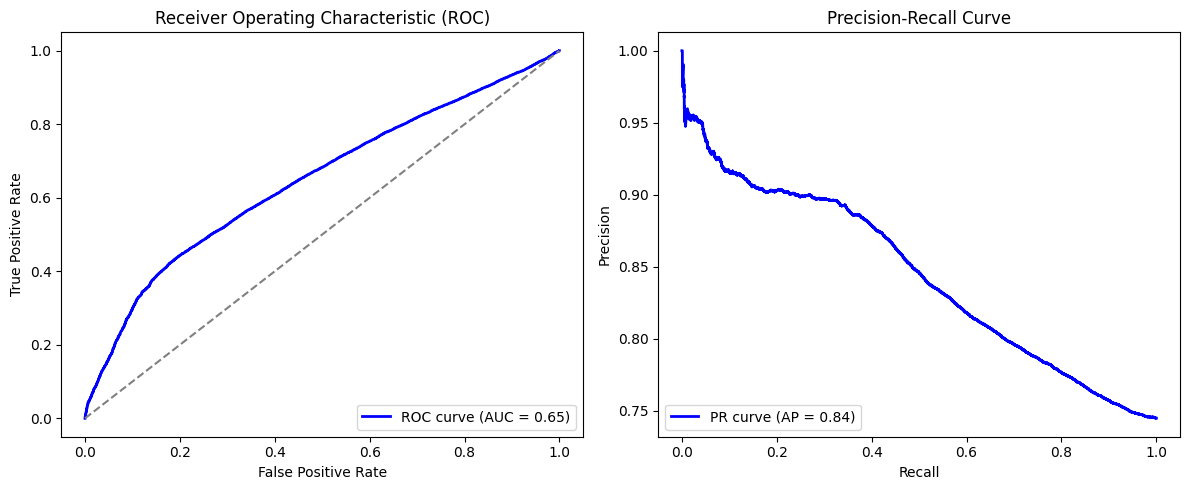

Epoch 48/50 | Train Loss: 0.3119 | Val Loss: 0.3163 | Val Acc: 0.5766


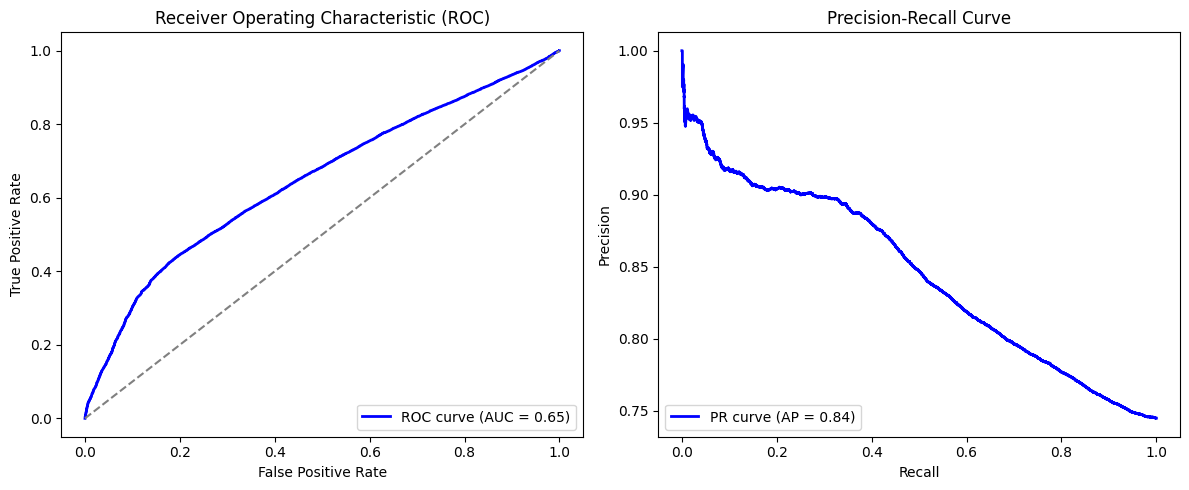

Epoch 49/50 | Train Loss: 0.3121 | Val Loss: 0.3213 | Val Acc: 0.5595


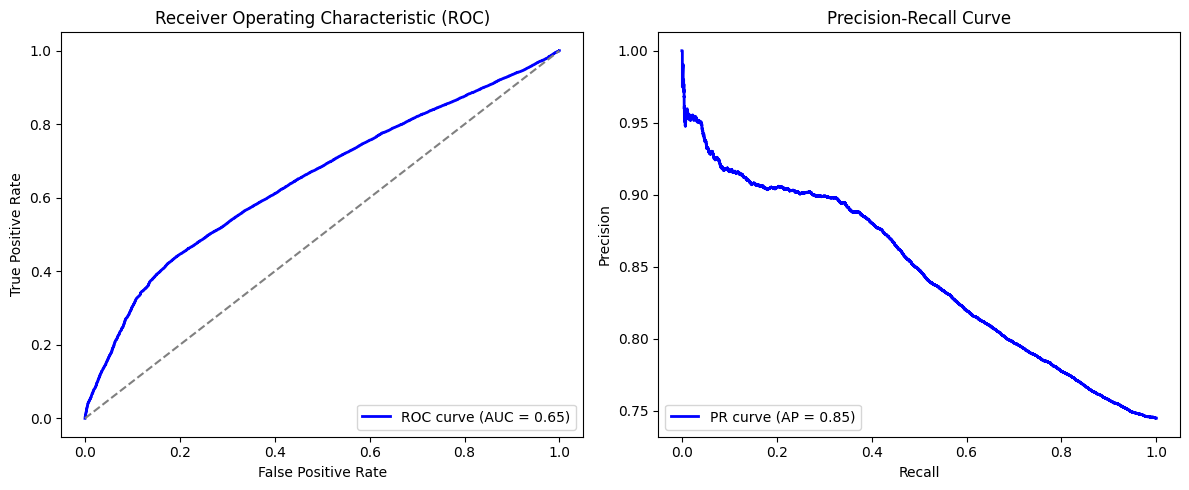

Epoch 50/50 | Train Loss: 0.3126 | Val Loss: 0.3532 | Val Acc: 0.5860


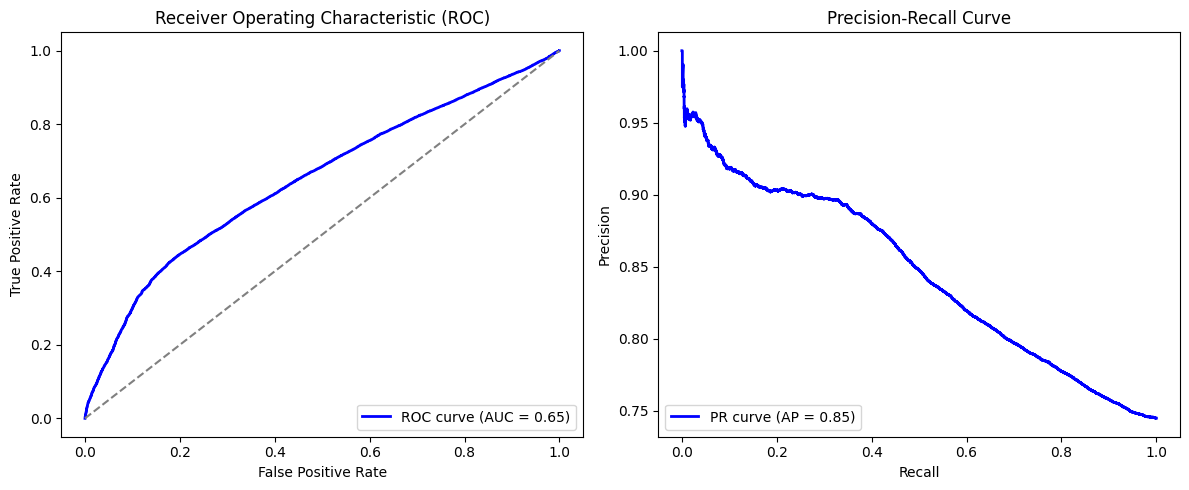

In [95]:
# Initialize model
input_length = 12000
model = CNNClassifier(input_length=input_length)

# Train
model = train_model(model, train_loader, val_loader, epochs=50, lr=1e-3)


Loss: 0.6038 | Acc: 0.6248 | AUC: 0.7042 | AP: 0.8860

Classification Report:
              precision    recall  f1-score   support

         0.0     0.3678    0.6617    0.4728       269
         1.0     0.8415    0.6122    0.7087       789

    accuracy                         0.6248      1058
   macro avg     0.6046    0.6369    0.5908      1058
weighted avg     0.7210    0.6248    0.6487      1058



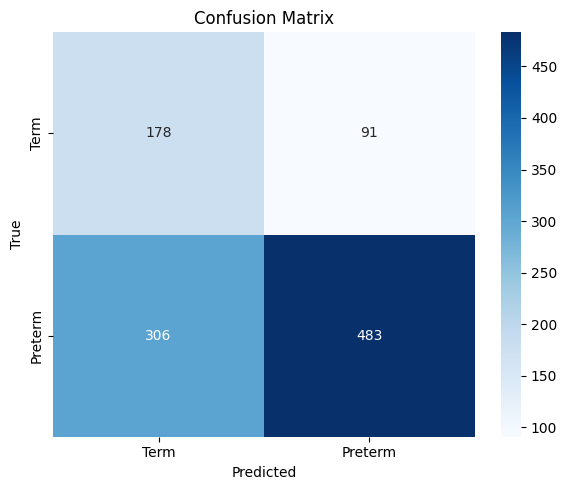

In [96]:
test_loss, test_acc, test_auc, test_ap = evaluate_model_with_metrics(model, test_loader, nn.BCEWithLogitsLoss())
